<h1>Logistische Regression mit MNIST</h1>

<p>Die lineare Regression findet eine Linearkombination der Eingangsdaten die die Zieldaten gut approximiert. Mit Hilfe der logistischen Regressionen können auch nicht-lineare Abbildungen gefunden werden. Außerdem eignet sie sich um binäre Aussagen zu treffen. Die heutige Übung verwendet das MNIST Datenset von Yann LeCun, welches Bilder von handgeschriebenen Ziffern beinhaltet. Ein Model der logistische Regression soll mit diesen Daten trainiert und im Anschluss getestet werden. Das fertige System soll in der Lage sein die Ziffer auf einen unbekannten Bild zu benennen.</p>

<p>Dieses Jupyter Notebook steht wieder zum <a href="http://home.htw-berlin.de/~hezel/computervision/WS1718/uebung2/LogisticRegression_MNIST_Vorlage.ipynb" target="_blank">download</a> bereit.</p>

<hr />

<h2>Vorbereitung</h2>

<p>Es ist Sinnvoll zun&auml;chst die Lineare Regression 2D in eine vektorisierte Variante zu &uuml;berf&uuml;hren um diesen Ansatz anhand eines Beispiels zu lernen welches bereits bekannt ist. Die Vektoren/Matrizen-Schreibweise ist f&uuml;r die nachfolgende &Uuml;bung unabdiengbar. Die Idee ist es alle Berechnungen (Prediction, Error usw) ohne for-loops auszurechnen. Das gilt ebenfalls für die partiellen Ableitungen die mit einer Matrix Multiplikation gelöst werden können. Auf diese Weise sind beliebig hoch dimensionale Eingangdaten verarbeitbar.</p>

<p><a href="http://home.htw-berlin.de/~hezel/computervision/WS1718/uebung1/#LinearRegression_2D_Vorlage.ipynb">http://home.htw-berlin.de/~hezel/computervision/WS1718/uebung1/#LinearRegression_2D_Vorlage.ipynb</a></p>

<hr />

<h2>Einleitung</h2>

<p>Scikit-learn liefert eine Methode um die MNIST Daten aus dem Internet zu laden. Leider ist deren Server etwas unzuverl&auml;ssig, weshalb wir die Daten selbst von einen HTW Server downloaden.</p>


In [1]:
from shutil import copyfileobj
from six.moves import urllib
from sklearn.datasets.base import get_data_home
from sklearn.datasets import fetch_mldata
import os

In [2]:
def fetch_mnist(data_home=None):
    mnist_alternative_url = "http://home.htw-berlin.de/~hezel/files/data/mnist-original.mat"    
    data_home = get_data_home(data_home=data_home)
    data_home = os.path.join(data_home, 'mldata')
    if not os.path.exists(data_home):
        os.makedirs(data_home)
    mnist_save_path = os.path.join(data_home, "mnist-original.mat")
    if not os.path.exists(mnist_save_path):
        print("Download MNIST to",mnist_save_path)
        mnist_url = urllib.request.urlopen(mnist_alternative_url)
        with open(mnist_save_path, "wb") as matlab_file:
            copyfileobj(mnist_url, matlab_file)
    return fetch_mldata('MNIST original')

In [3]:
mnist = fetch_mnist()
print(mnist)

{'DESCR': 'mldata.org dataset: mnist-original', 'COL_NAMES': ['label', 'data'], 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.]), 'data': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}


Die erhaltenden Daten teilen wir in Test und Trainingsdaten auf. Wobei wir darauf achten die Daten vorher zu mischen.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state

# input and output data
X = mnist.data.astype('float64')
y = mnist.target

# shuffle data
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=60000, test_size=10000)

<hr />
<h2>Daten Visualisierung</h2>

<p>Visualisieren sie von jeder Ziffer 5 Zahlen in einen 10x5 gro&szlig;en Grid. Die Ziffern sind alle in 28x28 Pixel gro&szlig;en graustufen Bildern gespeichert. Jede Zeile von X representieren eine Zahl. Ist der Zeilenindex bekannt, kann die Zeile mit numpy.take(...) extrahiert werden.</p>


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# enable interactive plots
%matplotlib notebook

In [17]:
# TODO Plots 50 images in a 10x5 grid.
vis_matrix = np.zeros([10, 5, 28, 28])

for number in range(0, 10):
    idxs, = np.where(y == number)
    idxs= idxs[:5]
#     print(idxs)
    images = X[idxs].reshape([5, 28, 28])
#     print(images.shape)
    vis_matrix[number] = images

print(vis_matrix.shape)
vis_matrix = vis_matrix.reshape([10*28, 5*28])
plt.imshow(vis_matrix)

(10, 5, 28, 28)


<hr />
<h2>Daten Normalisierung</h2>

<p>Solange wie die Eingangsdaten (x) in ein Regression-Model normalisiert sind k&ouml;nnen Lernraten zwischen 0.1 und 1.0 verwendet werden. &Auml;ndert sich der Wertebereich dieser Daten, werden komplett andere Learnraten ben&ouml;tigt. Es ist also Sinnvoll die Daten immer vorher zwischen 0 und 1 zu normalisieren.</p>


In [7]:
print(X_train.min(), X_train.max())
print(X_test.min(), X_test.max())

0.0 255.0
0.0 255.0


In [8]:
# TODO Normalize the data.
X_train = X_train / 255.
X_test = X_test / 255.

<hr />
<h2>One-Hot-Encoding</h2>

<p>Die logistische Regression liefert als Ergebnis Werte zwischen 0 und 1. Damit ist&nbsp;zun&auml;chst keine Multi-Klassen Klassifikation m&ouml;glich, die f&uuml;r das MNIST Beispiel aber notwendig ist. Deswegen m&uuml;ssen die Zieldaten (y) mit dem One-vs-All Ansatz oder auch One-Hot-Encoding genannt transformiert werden. Das Ergebnis sind&nbsp;y_train und y_test Matrizen im Shape von 60000x10 bzw. 10000x10.&nbsp;</p>


In [9]:
# TODO Apply One-Hot-Encoding on the y-Data
y_train = np.eye(10)[y_train.astype(int)]
y_test = np.eye(10)[y_test.astype(int)]

print('y_train.shape', y_train.shape)
print('y_test.shape', y_test.shape)

y_train.shape (60000, 10)
y_test.shape (10000, 10)


<hr />
<h2>Training</h2>

<p>Nutzen sie die logistischen Regression um ein Model zu trainieren welches f&uuml;r ein 28x28 Pixel Bild die darauf befindliche Ziffer vorhersagt. Notieren sie sich den Trainingsfehler bez&uuml;glich der Trainings- und Testdaten, sowie die Vorhersagegenautigkeit mit Hilfe der Testdaten. Die Regression liefert f&uuml;r alle eingehenden Daten jeweils einen Vektor mit 10 Dimensionen. Die Dimension die den h&ouml;chsten Wert liefert, gilt als Gewinner und wird verglichen mit dem Gewinner des One-Hot-Vektors. Auf diese Weise l&auml;sst sich ermitteln wie h&auml;ufig die Regression richtig lag (Vorhersagegenautigkeit).</p>

<p>Wird die Differenz zwischen den beiden Vektoren ermittelt, k&ouml;nnen mit Hilfe der partiellen Ableitung die Gewichts-/Theta-Werte angepasst werden, sodass in Zukunft die Differenz kleiner ausf&auml;llt. Au&szlig;erdem ist es m&ouml;glich den Mean-Squared-Error der Trainingsdaten anhand dieser Differenz auszurechnen (Trainingsfehler).</p>


In [10]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

print(sigmoid(0))

0.5


In [26]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [33]:
def cost(y_pred, y_train):
    cost_train = 1/2 * np.sum(np.square(y_pred - y_train))

In [34]:
def log_cost(y_pred, y, m):
    return (- 1 / m) * np.sum(y * np.log(y_pred) + (1 - y) * (np.log(1 - y_pred)))  # compute cost

In [37]:
def calc_error(y_pred, y):
    return 100 - np.mean(np.abs(y_pred - y))

In [43]:
# TODO Build a logist regression model, using the sigmoid as the activation function and the MSE as the loss function.

# pixel count
img_size_flat = 28 * 28

# num of classes
num_classes = 10

# initial theta-values
# weights = np.random.randn(img_size_flat, num_classes)
weights = np.random.randn(img_size_flat, num_classes).astype(np.float32) * np.sqrt(2.0/(784))

# learn rate
m = len(X_train)
alpha = 0.5/ m

# predictions per iteration
train_costs = []
test_costs = []

# train for 30 iterations
for i in range(60):
    
    # prediction
    y_pred = sigmoid(np.dot(X_train, weights))
    cost_train = log_cost(y_pred, y_train, m)
    train_costs.append(cost_train)
    
    # derivative
    d_weights = np.dot(X_train.T, y_pred - y_train)

    # update weights
    weights = weights - alpha * d_weights
    
    # print error
    print("[{:2d}] cost: {:.3f}".format(i, cost_train))
    
    # test
    y_pred_test = sigmoid(np.dot(X_test, weights))
    cost_test = log_cost(y_pred_test, y_test, m)
    test_costs.append(cost_test)

y_pred = sigmoid(np.dot(X_test, weights))
y_pred_max = (y_pred == y_pred.max(axis=1)[:,None]).astype(int)

print('Test Accuracy: {:.2f}%'.format(100 - np.mean(np.abs(y_pred_max - y_test)) * 100))

[ 0] cost: 6.947
[ 1] cost: 6.282
[ 2] cost: 4.297
[ 3] cost: 2.803
[ 4] cost: 2.140
[ 5] cost: 1.955
[ 6] cost: 1.862
[ 7] cost: 1.787
[ 8] cost: 1.723
[ 9] cost: 1.669
[10] cost: 1.621
[11] cost: 1.579
[12] cost: 1.542
[13] cost: 1.509
[14] cost: 1.479
[15] cost: 1.452
[16] cost: 1.428
[17] cost: 1.405
[18] cost: 1.384
[19] cost: 1.365
[20] cost: 1.347
[21] cost: 1.330
[22] cost: 1.315
[23] cost: 1.300
[24] cost: 1.286
[25] cost: 1.273
[26] cost: 1.261
[27] cost: 1.250
[28] cost: 1.239
[29] cost: 1.229
[30] cost: 1.219
[31] cost: 1.209
[32] cost: 1.201
[33] cost: 1.192
[34] cost: 1.184
[35] cost: 1.176
[36] cost: 1.169
[37] cost: 1.162
[38] cost: 1.155
[39] cost: 1.148
[40] cost: 1.142
[41] cost: 1.136
[42] cost: 1.130
[43] cost: 1.124
[44] cost: 1.119
[45] cost: 1.113
[46] cost: 1.108
[47] cost: 1.103
[48] cost: 1.099
[49] cost: 1.094
[50] cost: 1.089
[51] cost: 1.085
[52] cost: 1.081
[53] cost: 1.077
[54] cost: 1.073
[55] cost: 1.069
[56] cost: 1.065
[57] cost: 1.062
[58] cost: 1.0

<hr />
<h2>Plotten der Trainingsfehler und Testgenauigkeit</h2>

<p>Erzeugen sie einen Plot der den Trainings- und den Testfehler in Abh&auml;ngigkeit der Trainingsiteration in einem Diagramm anzeigt.</p>


<IPython.core.display.Javascript object>


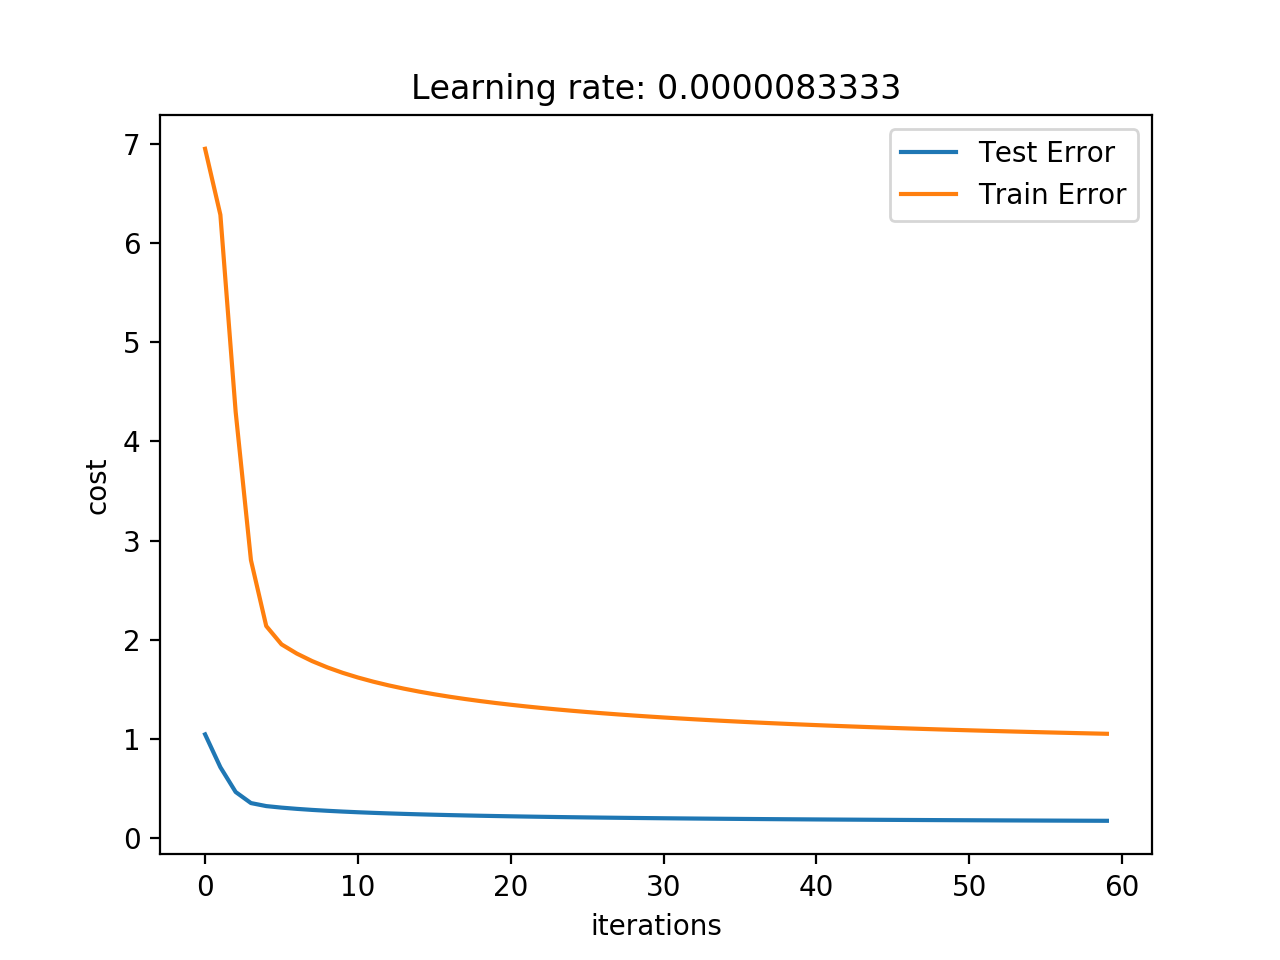

In [44]:
plt.figure(1)
plt.plot(test_costs, label='Test Error')
plt.plot(train_costs, label='Train Error')
plt.legend()
plt.ylabel('cost')
plt.xlabel('iterations')
plt.title("Learning rate: {:.10f}".format(alpha))
plt.show()

<hr />
<h2>Visualisierung der Weights</h2>

<p>Im folgenden wird die Gesichtsmatrix visualisiert. Dadurch soll ersichtlich werden, was die Machine gelernt hat. Je nach Fehlerfunktion und Trainingsalgorithmus sind die entstehenen Bilder mehr oder weniger aufschlussreich für uns Menschen.</p>


In [14]:
def plot_weights(w):
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape((28,28))

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])

<IPython.core.display.Javascript object>


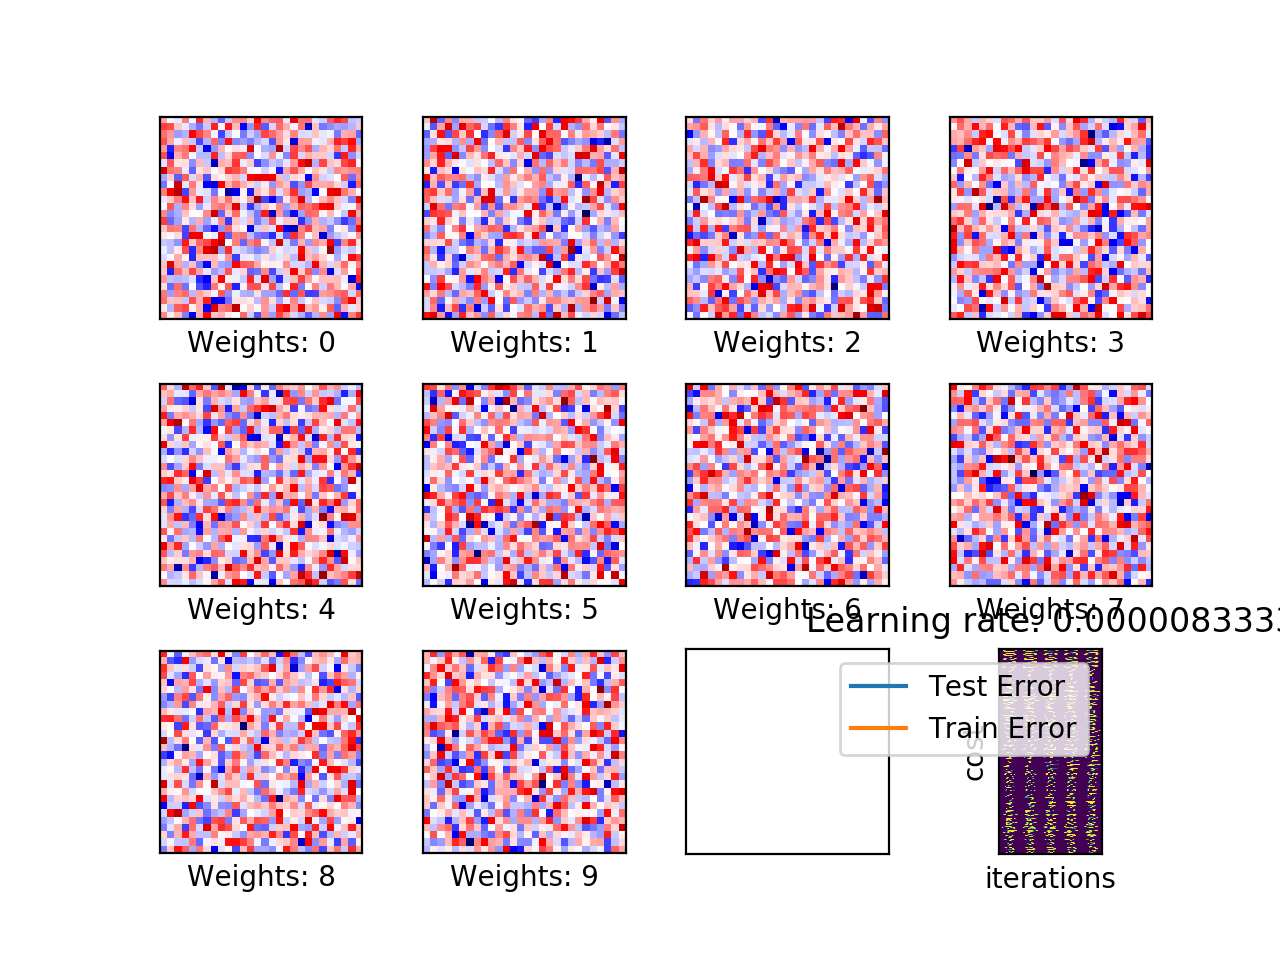

In [15]:
plot_weights(weights)

<hr />

<h2>Abgabe</h2>

<p>Das von ihnen erstellte Notebook muss sp&auml;testens bis zum 10. Dezember 2017 um 23:59 UTC+1 per E-Mail an&nbsp;<a href="mailto:hezel@htw-berlin.de" target="_blank">hezel@htw-berlin.de</a>&nbsp;eingesendet werden. Verwenden sie als Betreff bitte &quot;CV1718 &Uuml;bung2 &lt;NAME&gt;&quot; und als Notebook Name &quot;CV1718_Ue2_LogisticRegression_MNIST_NAME.ipynb&quot;. Bevor sie mir eine Mail schicken, entfernen sie bitte &uuml;ber &quot;Kernel&quot; -&gt; &quot;Restart and Clear Output&quot; s&auml;mtlichen von Python erstellten Inhalt und speichern anschlie&szlig;end das Notebook &quot;File&quot; -&gt; &quot;Save and Checkpoint&quot;.</p>
